In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
plt.style.use("dark_background")
plt.rcParams['figure.dpi']= 125

In [2]:
file_strs = ['cal_1', 'ave']
path = '../data/astroskipper_images/smart_cal_1/'
# Flipped = False
i_amp = 0
scale = None
N = r'15'
figname_prefix = fr'Cal1_N_{N}_'

In [3]:
def gen_image_dict(path, flipped=False):
    image_dict = {}
    filenames = os.listdir(path=path)
    filenames.sort()
    for filename in filenames:
        if all(string in filename for string in file_strs):
            if flipped:
                if 'flipped' in filename:
                    name = path + filename
                    image_dict[filename[:]] = fits.open(name=name)
            else:
                if 'flipped' not in filename:
                    name = path + filename
                    image_dict[filename[:]] = fits.open(name=name)
    if image_dict:
        return image_dict
    else:
        print("Image dict is empty!")

image_dict = gen_image_dict(path)    
flipped_image_dict = gen_image_dict(path, flipped=True)

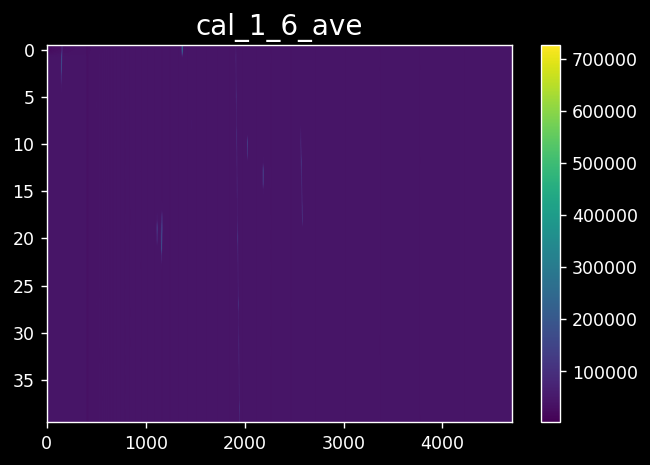

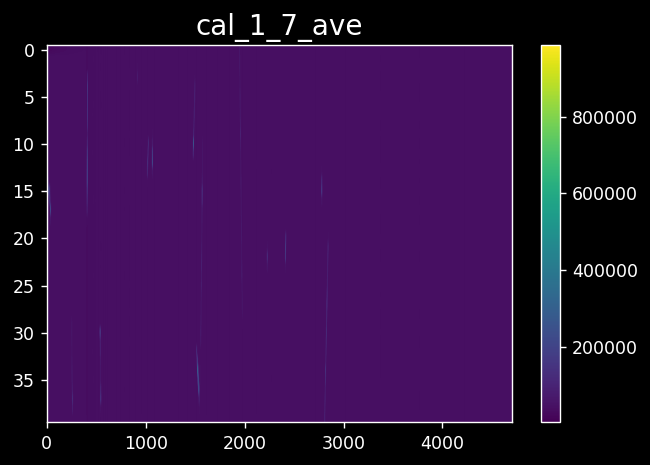

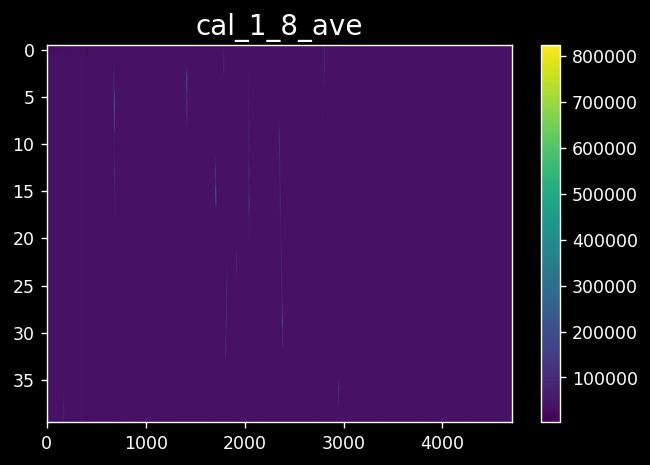

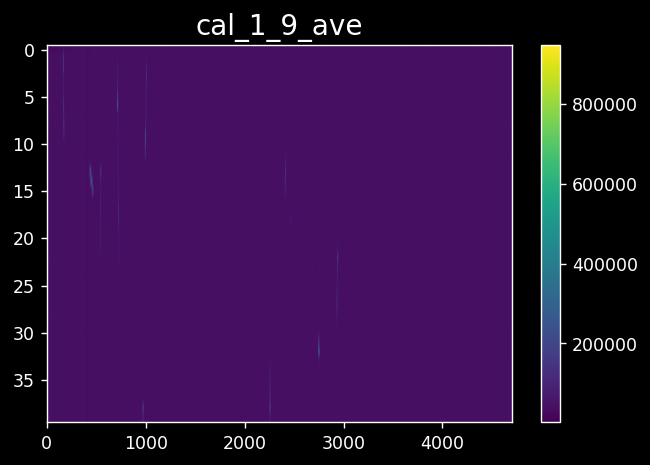

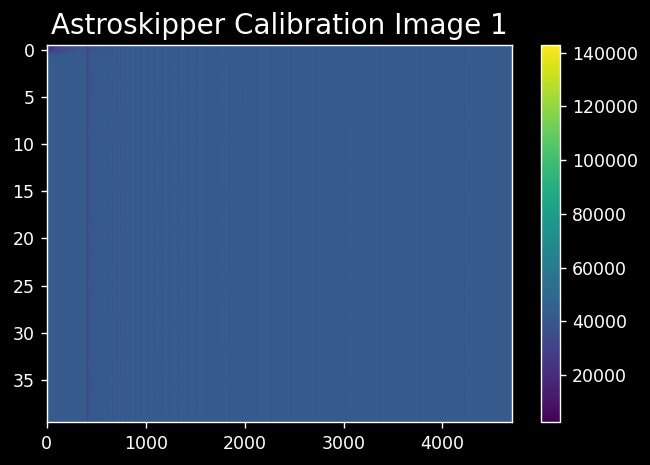

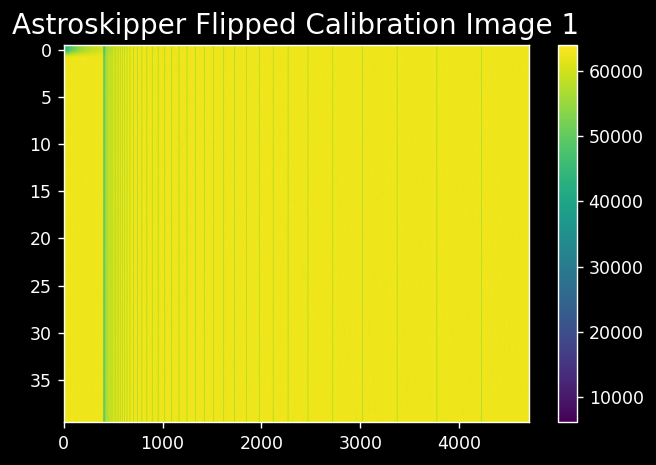

In [4]:
def plot_images(image_dict, i_amp, scale, origin='upper'):
    if scale == 'negative':
        scale = -1
    else:
        scale = 1
    for key in image_dict:
        plt.imshow(scale*image_dict[key][i_amp].data,
                   origin=origin,
                   aspect='auto')
        if 'ave' in file_strs:
            title = key[:-5]
        elif 'fits' in file_strs:
            title = key[:-3]
        else:
            title = key
        plt.title(title, fontsize=16)
        plt.colorbar()
        plt.show();
        
def get_median_image(image_dict, i_amp, scale, origin='upper', plot=True, flipped=False):
    if scale == 'negative':
        scale = -1
    else:
        scale = 1
    median_image = scale*np.median(np.array([image_dict[key][i_amp].data for key in image_dict]), axis=0)
    if plot:
        plt.imshow(median_image, origin=origin, aspect='auto')
        plt.title('Astroskipper Calibration Image 1', fontsize=16)
        if flipped:
            plt.title('Astroskipper Flipped Calibration Image 1', fontsize=16)
        plt.colorbar();
    return median_image

plot_images(image_dict, i_amp, scale=scale)
# plot_images(flipped_image_dict, i_amp, scale=scale)
median_image = get_median_image(image_dict, i_amp, plot=True, scale=scale)
plt.savefig(fname=figname_prefix + 'image')
plt.show();
flipped_median_image = get_median_image(flipped_image_dict, i_amp, plot=True, scale=scale, flipped=True)
plt.savefig(fname=figname_prefix + 'image_Flipped')

In [5]:
# omit first row b/c not reliable
mean_row = np.mean(median_image[1:], axis=0)
median_row = np.median(median_image[1:], axis=0)
column_indices=np.arange(len(mean_row))

flipped_mean_row = np.mean(flipped_median_image[1:], axis=0)
flipped_median_row = np.median(flipped_median_image[1:], axis=0)

flipped=False
if flipped==True:
    median_row = flipped_median_row
    mean_row = flipped_mean_row
    
# get centers
# centers = [1, 1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 60, 80, 100, 130, 160, 190, 220, 250, 280, 310, 340, 370, 400, 430]
centers = np.array([401, 402, 404, 407, 411, 416, 422, 429, 437, 446, 456, 467, 479, 492, 506, 521, 537, 554, 572, 591, 611, 636, 666, 701, 741, 786, 836, 891, 951, 1016, 1086, 1161, 1241, 1326, 1416, 1511, 1611, 1721, 1841, 1971, 2111, 2261, 2461, 2711, 3011, 3361, 3761, 4211])
centers -= 1

where_centers = np.zeros(len(mean_row), dtype=bool)
where_centers[centers] = True

hotcol_index = np.argwhere(mean_row > 120000)[0][0] # 120000 from checking P_1_only
where_hotcol = np.zeros(len(mean_row), dtype=bool)
where_hotcol[hotcol_index] = True

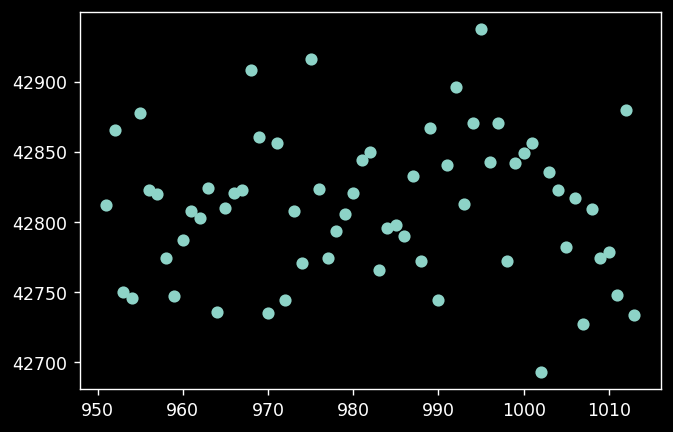

In [6]:
# plot of sequence of N=1 after N=15 at 950
plt.scatter(column_indices[centers[-20]+1:centers[-19]-1], median_row[centers[-20]+1:centers[-19]-1])

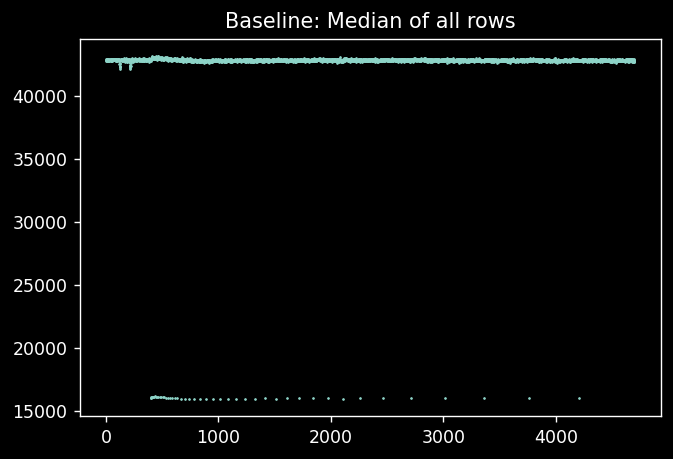

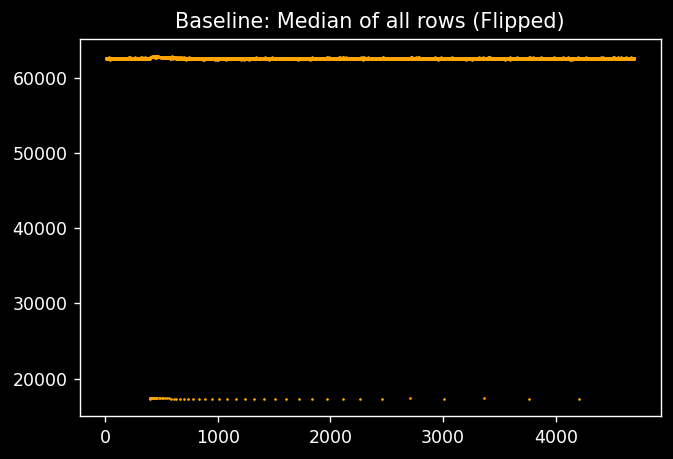

In [7]:
# [10:] b/c skipping a "hot column/pixel"
plt.scatter(column_indices[~where_hotcol][1:], median_row[~where_hotcol][1:], linewidth=.5, s=1)
# plt.plot(flipped_median_row[1:], linewidth=.5, label='flipped')
# plt.scatter(np.arange(0, len(median_row), 1), median_row, s=.5, color='black')
plt.title('Baseline: Median of all rows')
# plt.xlim(400,1000)
plt.savefig(fname=figname_prefix + 'Pre-corrected_baseline')
plt.show();

plt.scatter(np.arange(0,len(flipped_median_row[1:]), 1)[10:], flipped_median_row[1:][10:],
            linewidth=.5,
            s=1,
            color='orange')
# plt.plot(flipped_median_row[1:], linewidth=.5, label='flipped')
# plt.scatter(np.arange(0, len(median_row), 1), median_row, s=.5, color='black')
plt.title('Baseline: Median of all rows (Flipped)')
# plt.xlim(400,1000)
plt.savefig(fname=figname_prefix + 'Pre-corrected_baseline_Flipped')

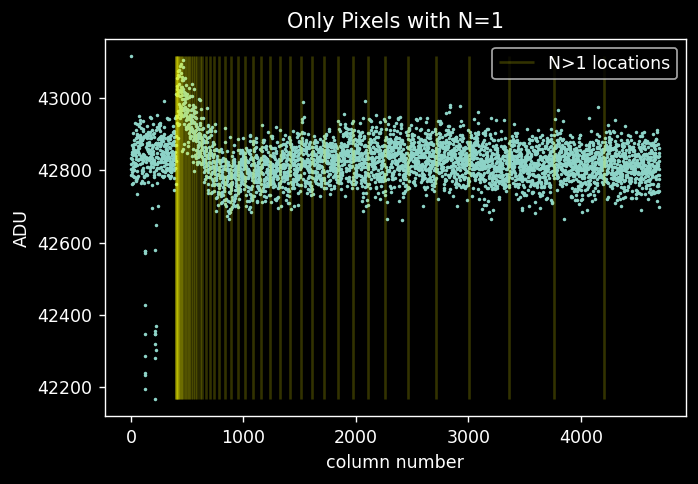

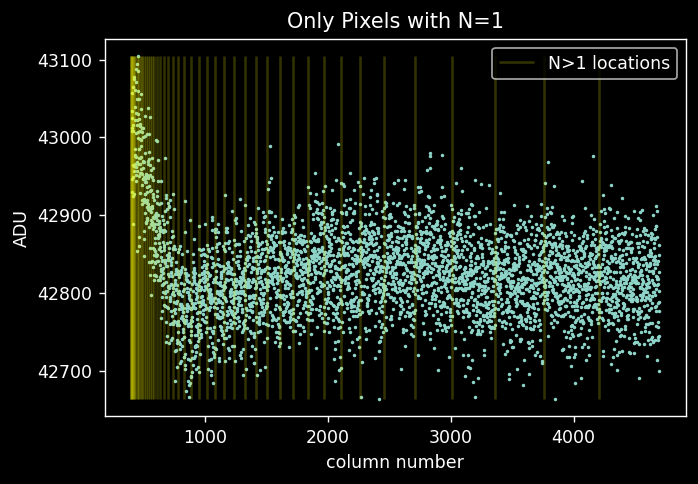

In [8]:
p_1_xs = np.arange(0, len(mean_row))[~where_centers & ~where_hotcol]
plt.scatter(p_1_xs, mean_row[~where_centers & ~where_hotcol], s=1)
plt.title('Only Pixels with N=1')
plt.xlabel("column number")
plt.ylabel("ADU")
plt.vlines(x=centers,
           ymin=np.min(mean_row[~where_centers & ~where_hotcol]),
           ymax=np.max(mean_row[~where_centers & ~where_hotcol]),
           alpha=.2,
           color='yellow',
           label='N>1 locations')
plt.legend()
plt.savefig(figname_prefix + "P_1_only")
plt.show();

p_1_xs = np.arange(0, len(mean_row))[~where_centers & ~where_hotcol]
plt.scatter(p_1_xs[400:], mean_row[~where_centers & ~where_hotcol][400:], s=1)
plt.title('Only Pixels with N=1')
plt.xlabel("column number")
plt.ylabel("ADU")
plt.vlines(x=centers,
           ymin=np.min(mean_row[~where_centers & ~where_hotcol][400:]),
           ymax=np.max(mean_row[~where_centers & ~where_hotcol][400:]),
           alpha=.2,
           color='yellow',
           label='N>1 locations')
plt.legend()
plt.savefig(figname_prefix + "P_1_only_cut")

In [9]:
a = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,500,1,500,1,1,500,1,1,1,500,1,1,1,1,500,1,1,1,1,1,500,1,1,1,1,1,1,500,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
len(a)

5000

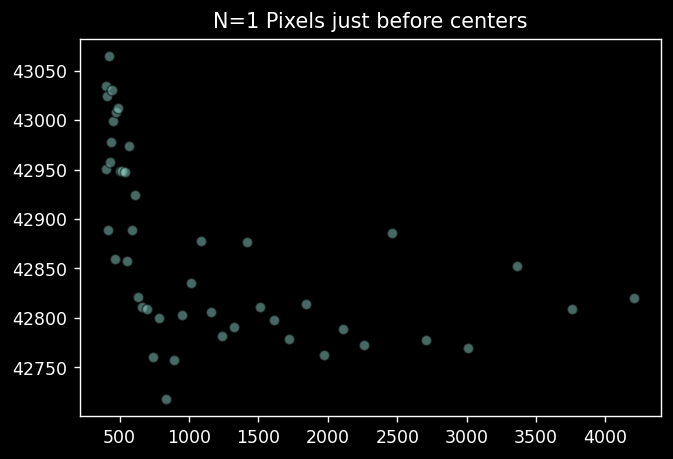

In [10]:
plt.scatter((centers-1)[2:], mean_row[centers-1][2:],
            edgecolors='black',
            alpha=.5)
plt.title('N=1 Pixels just before centers')
# plt.xlim(400, 2000)
plt.show();

# plt.scatter((centers-1)[10:], flipped_mean_row[centers-1][10:], color='orange')
# plt.title('N=1 Pixels just before centers (Flipped)')

In [11]:
# col_start = 400
# col_final = 500
# xs = np.arange(col_start, col_final)
# plt.scatter(xs, median_row[col_start:col_final], s=1)


###################################################################################################

# Generate lookup tables

In [12]:
from scipy import interpolate
from scipy import optimize

# define exponential func
def exp_func(x, A, C, D):
    return A*np.exp(-C*x)+D

## vertical clock effect for N=1

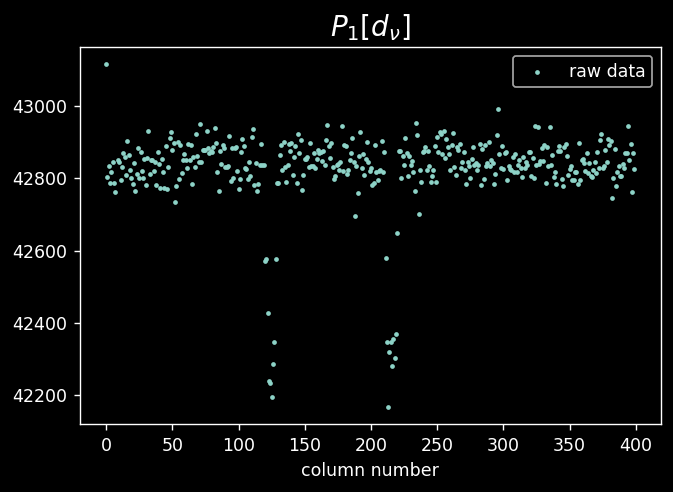

In [13]:
P_1_d_nu = mean_row[0:400]
d_nus = np.arange(0, len(P_1_d_nu))
P_1_d_nu = P_1_d_nu[~where_hotcol[0:400]]
d_nus = d_nus[~where_hotcol[0:400]]
plt.scatter(d_nus, P_1_d_nu, s=3, label='raw data')

## fit exponential to data...
# popt, pcov = optimize.curve_fit(f=exp_func, xdata=d_nus, ydata=P_1_d_nu, p0=(1e5, 1e-1, 1e5))
# plt.plot(d_nus,
#          exp_func(d_nus, *popt),
#          label='exponential fit',
#          color='yellow')

plt.title(r"$P_1[d_\nu]$", fontsize=16)
plt.xlabel('column number')
# plt.xlim(0, 50)
plt.legend()
plt.savefig(fname=figname_prefix+'P_1[d_nu]')

In [14]:
# set steady state val
P_1_SS = np.average(P_1_d_nu[-5:])
P_1_SS

42840.75

## Last multisample pixel effect on a multisample pixel

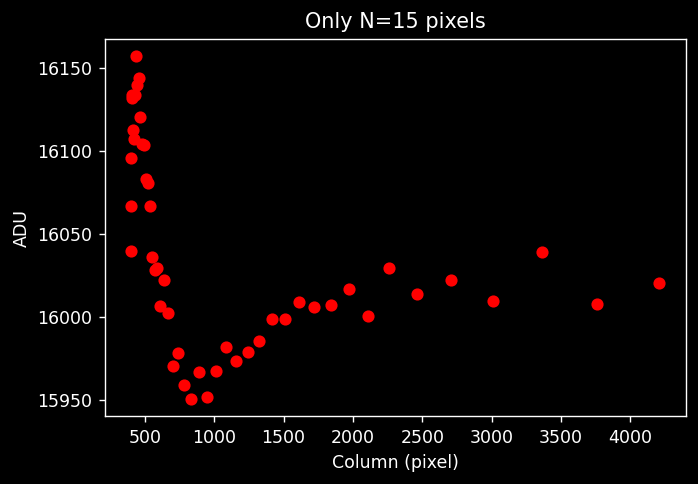

In [15]:
# plot just the N=15 pixels
# plt.scatter(np.arange(0, len(mean_row)), mean_row, alpha=.5)
plt.scatter(column_indices[where_centers], mean_row[where_centers],
#             edgecolors='white',
            color='red')
plt.title("Only N=15 pixels")
plt.xlabel("Column (pixel)")
plt.ylabel("ADU")
# plt.ylim(40000, 100000)
plt.savefig(fname=figname_prefix + "P_15_only")
plt.show();

In [16]:
np.min(mean_row[centers])-np.max(mean_row[centers])

-206.38281

In [17]:
np.std(mean_row[centers])/162

0.36021830711835695

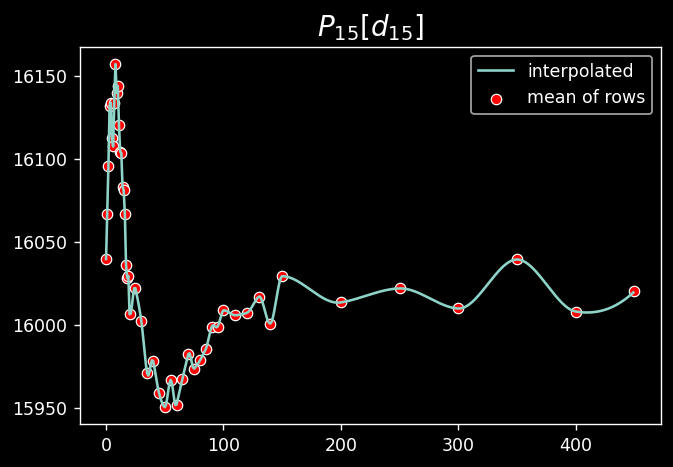

In [18]:
P15_d15 = mean_row[centers]
P15_d15_xs = np.concatenate((np.array([0]), np.diff(centers)))
P15_d15_interp_xs = np.arange(P15_d15_xs[0], P15_d15_xs[-1], 1)
P15_d15_interpolated = interpolate.Akima1DInterpolator(P15_d15_xs, P15_d15)(P15_d15_interp_xs)

# P15_d15_interpolated = np.concatenate((np.full(shape=1, fill_value=P_15_d_15[0]), 
#                                        P_15_d_15_interpolated,
#                                        np.full(shape=500, fill_value=P_15_d_15[-1])))
# P15_d15_interp_xs = np.concatenate((np.array([0]),
#                                  P15_d15_interp_xs, 
#                                  np.arange(P15_d15_interp_xs[-1]+1, len(P_15_d_15_interpolated), dtype=np.int64)))

plt.scatter(P15_d15_xs, mean_row[centers],
            color='red',
            edgecolors="white",
            linewidth=.7,
            label='mean of rows')
plt.plot(P15_d15_interp_xs, P15_d15_interpolated, label='interpolated')
# plt.scatter(np.diff(centers), median_image[jj][centers[1:]], label='row ' + str(jj), alpha=.5)
# plt.scatter(np.diff(centers), median_image[ii][centers[1:]], label='row ' + str(ii), alpha=.5)

plt.title(r"$P_{15}[d_{15}]$", fontsize=16)
plt.legend()
plt.savefig(fname=figname_prefix+'P_15[d_15]_interpolated')

# Effect on single sample from multisample

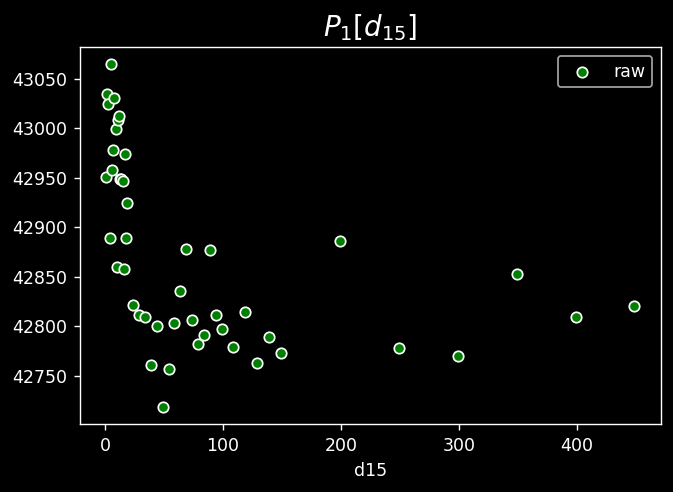

In [19]:
P_1_centers = centers[2:]-1
P1_d15_xs = (np.diff(centers)-1)[1:]
P1_d15 = mean_row[P_1_centers]

plt.scatter(P1_d15_xs, P1_d15,
            edgecolors='white',
            color='green',
            label='raw')
plt.title(r'$P_1[d_{15}]$', fontsize=16)
plt.legend()
plt.xlabel('d15')
plt.savefig(fname=figname_prefix+f'P_1[d_{N}]')

(0.0, 80.0)

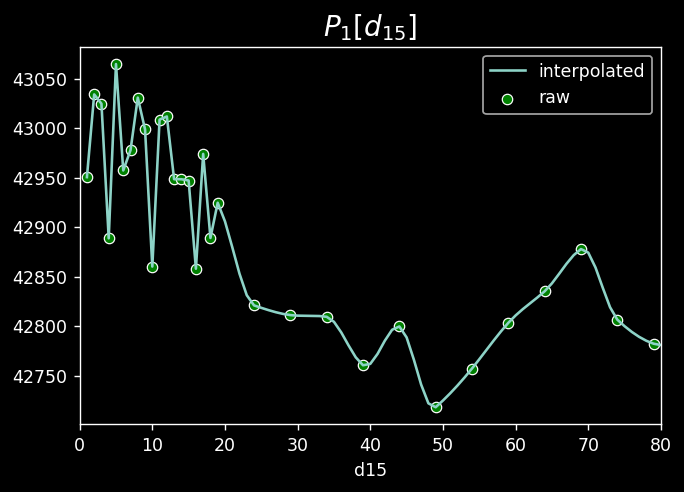

In [20]:
P1_d15_interp_xs = np.arange(P1_d15_xs[0], P1_d15_xs[-1], 1)
P1_d15_interpolated = interpolate.Akima1DInterpolator(P1_d15_xs, P1_d15)(P1_d15_interp_xs)


## But we need P_1_d_N as it goes from 0 to ~1000 if we want to test on one of our images.
## lets fill in the last few hundred with just the last value of P_1_d_N
# P1_d15_interpolated = np.concatenate((np.full(shape=1, fill_value=P1_d15[0]), 
#                                        P1_d15_interpolated,
#                                        np.full(shape=500, fill_value=P1_d15[-1])))
# P15_d15_xs_interp = np.concatenate((np.array([1]),
#                                  P1_d15_xs_interp, 
#                                  np.arange(P1_d15_xs_interp[-1]+1, len(P1_d15_interpolated), dtype=np.int64)))
## get exponential fit w/r to interpolated data
# popt, pcov = optimize.curve_fit(f=exp_func, xdata=P_15_d_15_xs_interp, ydata=P_1_d_N_interpolated, p0=(1e5, 1e-1, 1e5))

## get exponential fit w/r to raw data
popt, pcov = optimize.curve_fit(f=exp_func, xdata=P1_d15_xs, ydata=P1_d15, p0=(1e5, 1e-1, 1e5))


## plot
plt.plot(P1_d15_interp_xs, P1_d15_interpolated, label='interpolated')
plt.scatter(P1_d15_xs, P1_d15,
            edgecolors='white',
            color='green',
            linewidths=.7,
            label='raw')
# plt.plot(P_15_d_15_xs_interp, exp_func(P_15_d_15_xs_interp, *popt), label='exponential')
plt.title(r'$P_1[d_{15}]$', fontsize=16)
plt.legend()
plt.xlabel('d15')
plt.savefig(fname=figname_prefix+f'P_1[d_{N}]_interpolated')
plt.xlim(0, 80)

# Take calibration image and subtract baseline - we should get almost perfect results for (1) multisample pixels and (2) single-sample pixels that are located just before the multi-sample pixel

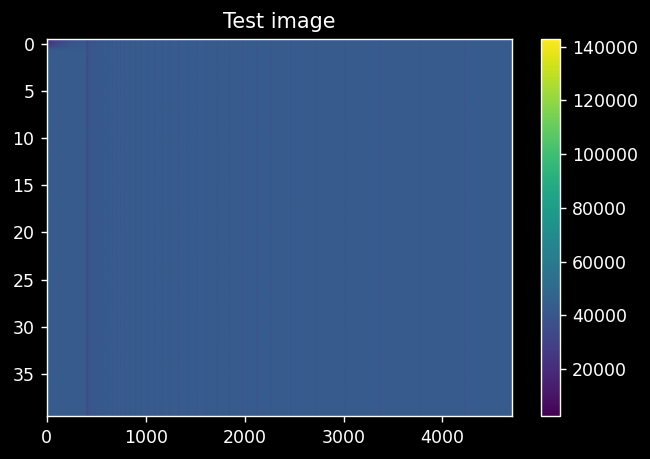

In [21]:
# data = image_dict['cal_1_8_ave.fits'][i_amp].data

data = median_image
plt.imshow(data,
           aspect='auto',
           origin='upper')
plt.title('Test image')
plt.colorbar();
plt.show();

In [22]:
## TODO: create func: image(x, NCOLCLUSTER, NROWCLUSTER) --> x_expanded (units pixel)

x_expanded = np.ones(shape=(median_image.shape[0], median_image.shape[1]), dtype=np.int64)
for i, row in enumerate(x_expanded):
    for j, val in enumerate(row):
        if np.any(j == centers):
            x_expanded[i, j] = 500

In [23]:
dN_array = np.zeros_like(data.flatten(), dtype=np.int64)
distance = 0

## TODO: optimize for speed
for i, element in enumerate(x_expanded.flatten()):
    dN_array[i] = distance
    if element > 1:
        distance = 1
    elif element == 1 and distance != 0:
        distance += 1
dN_array = dN_array.reshape((x_expanded.shape[0], x_expanded.shape[1]))

In [24]:
def get_baseline_val(i_col_cur, N_cur, dN_cur, P1_dnu, P1_dN, PN_dN, PN_dnu, PN_SS, P1_SS, delta_V=5):
    '''Gets baseline value of one pixel.
    As is, function is essentially just subtracting P1_d15 or P15_d15 given nsamp of currente pixel
    '''
    if N_cur == 1: # if current pixel has # samples N=1, reassign PN_* arrays
#         P_N_d_nu = P_1_d_nu  # arrays of length ~500
        PN_dN = P1_dN
        PN_SS = P1_SS
    elif N_cur < 1:
        return "N_cur must be greater or equal to 1"
    if dN_cur >= i_col_cur:
#         baseline = P_N_d_N[d_N + delta_V] + P_N_d_nu[i_col_cur] - P_N_SS
        baseline = 0
    elif dN_cur < i_col_cur:
#         print('case 2')
        if i_col_cur >= len(PN_dN):
            baseline = PN_dN[-1]
        else:
            baseline = PN_dN[dN_cur]
    ##  
#     if N_cur == 1 and i_col_cur < 400:
#         P1_dnu = np.concatenate((P1_dnu, np.full(shape=5000, fill_value=P1_dnu[-1])))
#         baseline = P1_dnu[i_col_cur]
    return baseline

In [25]:
## TODO: optimize for speed
## TODO: need baseline for P_N as a function of vertical clock effect

def get_baseline(dynamic_variable_expanded,
                 dN_array,
                 PN_dnu,
                 PN_dN,
                 P1_dnu,
                 P1_dN,
                 PN_SS,
                 P1_SS,
                 get_baseline_func):
    """
    dN is the distance from current pixel's column number (dnu) to last sample with N=500
    dnu is distance to vertical clock in pixels
    """
#     corrected_image = np.empty(shape=(image_data.shape[0], image_data.shape[1]))
    baseline = np.zeros_like(dynamic_variable_expanded, dtype=np.float64)
    for i, row in enumerate(baseline):
        for j, pixel_val in enumerate(row):
            baseline[i, j] = get_baseline_func(i_col_cur=j,
                                               N_cur=dynamic_variable_expanded[i, j],
                                               dN_cur=dN_array[i, j],
                                               P1_dnu=None,
                                               P1_dN=P1_dN,
                                               PN_dN=PN_dN,
                                               PN_dnu=None,
                                               PN_SS=None,
                                               P1_SS=None,
                                               delta_V=5)
    return baseline

In [26]:
baseline = get_baseline(dynamic_variable_expanded=x_expanded,
                        dN_array=dN_array,
                        PN_dnu=None,
                        PN_dN=P15_d15_interpolated,
                        P1_dnu=None,
                        P1_dN=P1_d15_interpolated,#P_1_d_N_interpolated,
                        PN_SS=None,
                        P1_SS=None,
                        get_baseline_func=get_baseline_val)

In [27]:
baseline[1][where_centers]

array([    0.        , 16067.14746094, 16096.0703125 , 16131.98535156,
       16133.86035156, 16112.828125  , 16107.50195312, 16133.63964844,
       16157.11035156, 16139.81445312, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689,
       16019.72571689, 16019.72571689, 16019.72571689, 16019.72571689])

(15700.0, 16300.0)

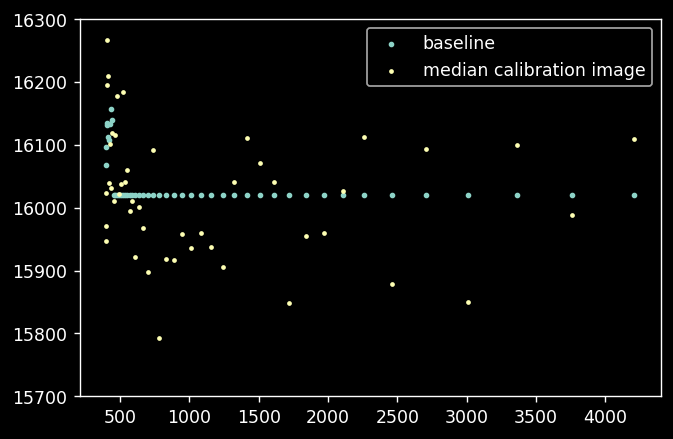

In [28]:
plt.scatter(column_indices[where_centers], baseline[5][where_centers], s=5,
            label='baseline')
plt.scatter(column_indices[where_centers], median_image[5][where_centers], s=3,
            label='median calibration image')
plt.legend();
plt.ylim(15700, 16300)

(40000.0, 45000.0)

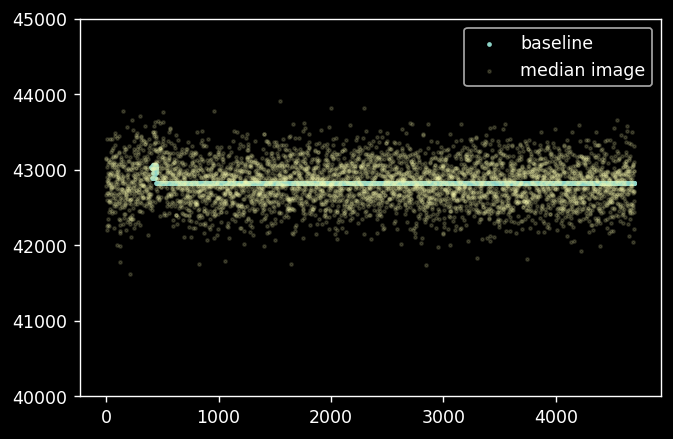

In [29]:
plt.scatter(column_indices[~where_centers & ~where_hotcol], baseline[-10][~where_centers & ~where_hotcol], s=3,
            label='baseline')
plt.scatter(column_indices[~where_centers & ~where_hotcol], median_image[-10][~where_centers & ~where_hotcol], s=3,
            alpha=.15,
            label='median image')
plt.legend()
plt.ylim(40000, 45000)

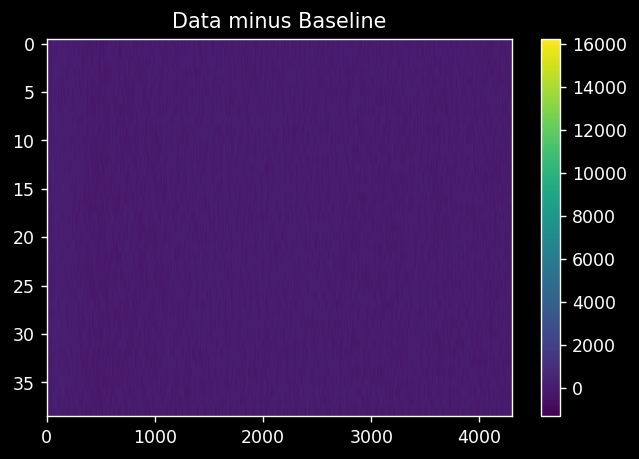

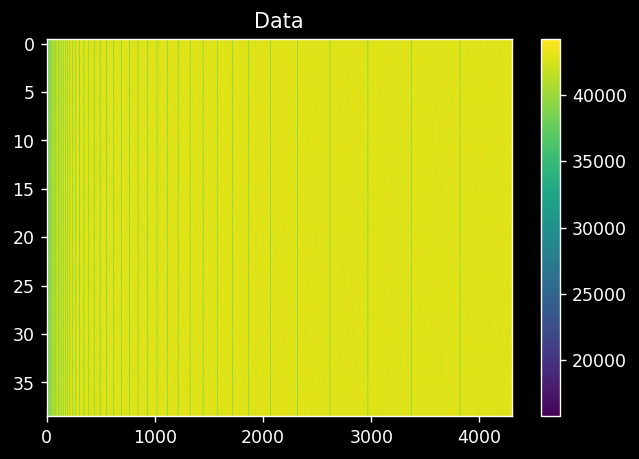

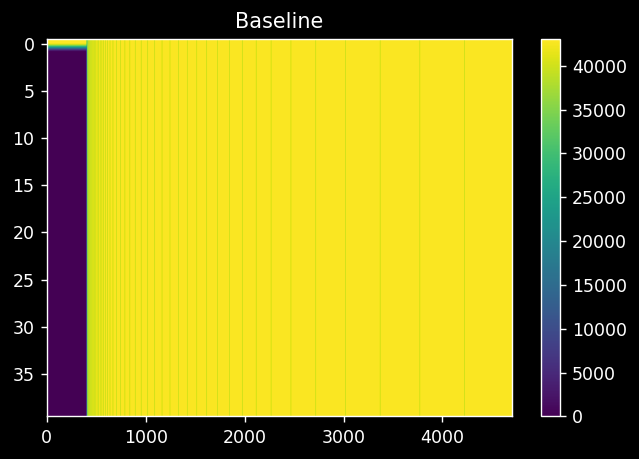

In [30]:
col_start = 400
col_final = -1

plt.imshow(data[1:,col_start:col_final]-baseline[1:,col_start:col_final],
           aspect='auto',
           origin='upper')
plt.title("Data minus Baseline")
plt.colorbar()
plt.show();

plt.imshow(data[1:,col_start:col_final],
           aspect='auto',
           origin='upper')
plt.title('Data')
plt.colorbar()
plt.show();

plt.imshow(baseline,
           aspect='auto',
           origin='upper',
           label='baseline'
           )
plt.title('Baseline')
plt.colorbar();

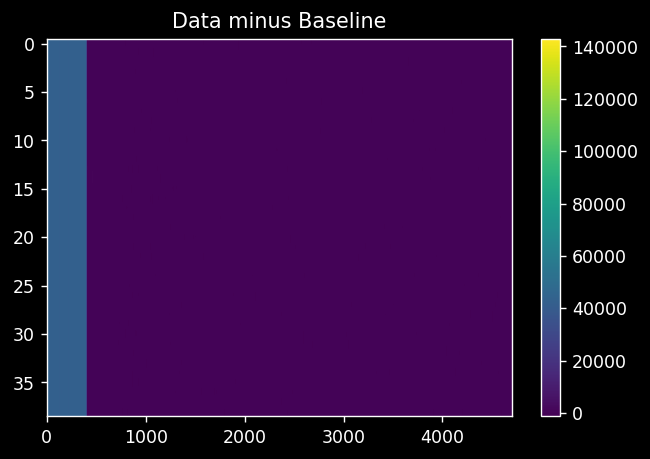

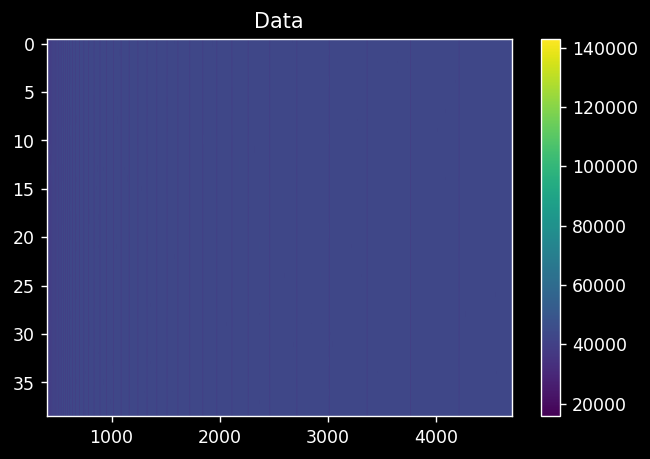

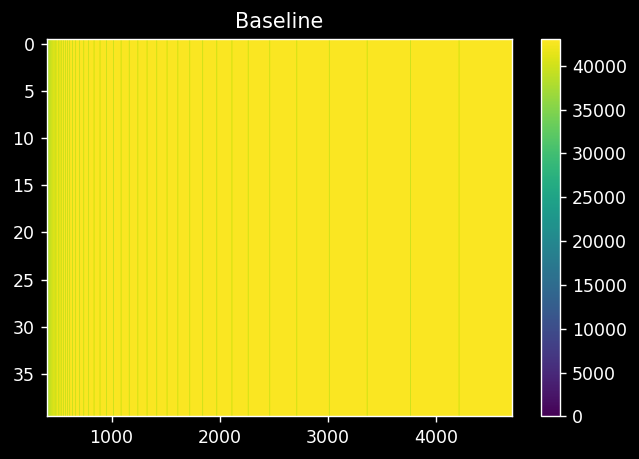

In [31]:
col_start = 400
col_final = len(data[0, :])

plt.imshow(data[1:]-baseline[1:],
           aspect='auto',
           origin='upper')
plt.title("Data minus Baseline")
plt.colorbar()
# plt.xlim(col_start, col_final)
plt.show();

plt.imshow(data[1:],
           aspect='auto',
           origin='upper')
plt.title('Data')
plt.xlim(col_start, col_final)
plt.colorbar()
plt.show();

plt.imshow(baseline,
           aspect='auto',
           origin='upper',
           label='baseline'
           )
plt.xlim(col_start, col_final)
plt.title('Baseline')
plt.colorbar();

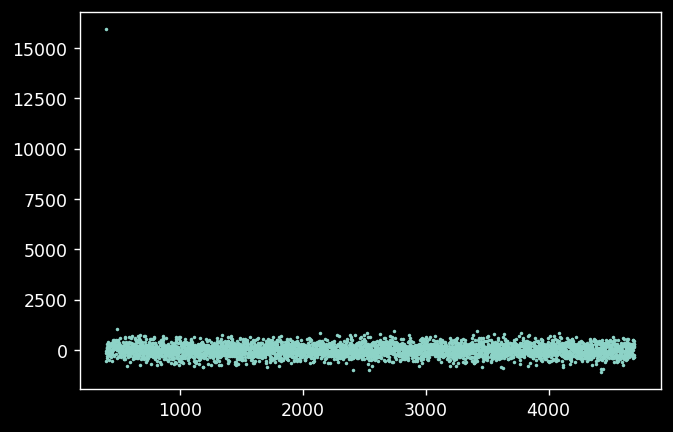

In [32]:
plt.scatter(column_indices[col_start:col_final], data[5,col_start:col_final]-baseline[5,col_start:col_final],
            s=1)

In [ ]:
iii = 5 # row
jjj = centers[-10]-1  # column
print('\n data: ', data[iii, jjj], '\n', 'baseline: ', baseline[iii, jjj])
print('\n dN: ', dN_array[iii, jjj])
print('\n P1_dN: ', P1_d15_interpolated[dN_array[iii,jjj]])

In [ ]:
get_baseline_val(i_col_cur=iii,
                 N_cur=x_expanded[iii, jjj],
                 dN_cur=dN_array[iii, jjj],
                 P1_dnu=None,
                 P1_dN=P1_d15_interpolated,
                 PN_dN=P15_d15_interpolated,
                 PN_dnu=None,
                 PN_SS=None,
                 P1_SS=None,
                 delta_V=0)